In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import pandas as pd

In [11]:
# Define transformations to apply to the data
transform = transforms.ToTensor()

# Load the CIFAR dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
torch.manual_seed(4)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [14]:
class CifarModel(nn.Module):
  def __init__(self, input, hidden_layer1, hidden_layer2, output):
        super(CifarModel, self).__init__()
        self.fc1 = nn.Linear(input, hidden_layer1)
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.out = nn.Linear(hidden_layer2, output)

  def forward(self, x):
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = torch.relu(self.out(x))
      return x

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from IPython.display import display

cifarModel = CifarModel(3072, 512, 256, 10).to(torch.device('cuda'))

criterion = FocalLoss()
optimizer = torch.optim.Adam(cifarModel.parameters(), lr=0.0001)

losses = []
accuracies = []
precisions_micro = []
recalls_micro = []
f1_scores_micro = []
precisions_macro = []
recalls_macro = []
f1_scores_macro = []
precisions_weighted = []
recalls_weighted = []
f1_scores_weighted = []

epoch = 100

for i in range(epoch):
  curr_loss = 0.0
  y_true = []
  y_pred = []

  for j, data in enumerate(train_loader):
    input, output = data[0].to(torch.device('cuda')), data[1].to(torch.device('cuda'))
    input = input.reshape(50, -1)

    optimizer.zero_grad()

    pred_out = cifarModel.forward(input)
    loss = criterion(pred_out, output)

    loss.backward()
    optimizer.step()

    curr_loss += loss.item()
    y_true += output.tolist()
    y_pred += torch.argmax(pred_out, dim=1).tolist()

  loss_avg = curr_loss / len(train_loader)
  losses.append(loss_avg)

  acc = accuracy_score(y_true, y_pred)
  accuracies.append(acc*100)

  precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=1)
  precisions_micro.append(precision_micro)
  recalls_micro.append(recall_micro)
  f1_scores_micro.append(f1_micro)

  precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)
  precisions_macro.append(precision_macro)
  recalls_macro.append(recall_macro)
  f1_scores_macro.append(f1_macro)

  precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=1)
  precisions_weighted.append(precision_weighted)
  recalls_weighted.append(recall_weighted)
  f1_scores_weighted.append(f1_weighted)
  print(f'epoch: {i:2}  loss: {loss_avg}')



perf_metrics = {
    'loss': losses,
    'accuracy': accuracies,
    'precision_micro': precisions_micro,
    'recall_micro': recalls_micro,
    'f1_micro': f1_scores_micro,
    'precision_macro': precisions_macro,
    'recall_macro': recalls_macro,
    'f1_macro': f1_scores_macro,
    'precision_weighted': precisions_weighted,
    'recall_weighted': recalls_weighted,
    'f1_weighted': f1_scores_weighted
}

perf_metrics_df = pd.DataFrame(perf_metrics)
display(perf_metrics_df)



epoch:  0  loss: 1.6281588613986968
epoch:  1  loss: 1.5376265927553177
epoch:  2  loss: 1.4621922241449357
epoch:  3  loss: 1.4148250914812088
epoch:  4  loss: 1.3877923540472985
epoch:  5  loss: 1.3661548935174943
epoch:  6  loss: 1.3462309497594833
epoch:  7  loss: 1.3322105376124382
epoch:  8  loss: 1.3187360795140266
epoch:  9  loss: 1.304832927942276
epoch: 10  loss: 1.2924062420725821
epoch: 11  loss: 1.2832852113842965
epoch: 12  loss: 1.2730301996469497
epoch: 13  loss: 1.2616254883408546
epoch: 14  loss: 1.2525000576376915
epoch: 15  loss: 1.2420014393329621
epoch: 16  loss: 1.2356184321045875
epoch: 17  loss: 1.2256201404333114
epoch: 18  loss: 1.2190988965630531
epoch: 19  loss: 1.2103671224117278
epoch: 20  loss: 1.2015360162258149
epoch: 21  loss: 1.1947935062050818
epoch: 22  loss: 1.1883573967814445
epoch: 23  loss: 1.1780198782682418
epoch: 24  loss: 1.1731302959918977
epoch: 25  loss: 1.1633190966844558
epoch: 26  loss: 1.1581547495126725
epoch: 27  loss: 1.1500476963

,loss,accuracy,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
0,1.628159,22.220,0.22220,0.22220,0.22220,0.523541,0.22220,0.155068,0.523541,0.22220,0.155068
1,1.537627,27.568,0.27568,0.27568,0.27568,0.575130,0.27568,0.200569,0.575130,0.27568,0.200569
2,1.462192,32.958,0.32958,0.32958,0.32958,0.615262,0.32958,0.255089,0.615262,0.32958,0.255089
3,1.414825,35.144,0.35144,0.35144,0.35144,0.529643,0.35144,0.271927,0.529643,0.35144,0.271927
4,1.387792,36.286,0.36286,0.36286,0.36286,0.638435,0.36286,0.281392,0.638435,0.36286,0.281392
...,...,...,...,...,...,...,...,...,...,...,...
95,0.877715,55.130,0.55130,0.55130,0.55130,0.846688,0.55130,0.473582,0.846688,0.55130,0.473582
96,0.878865,55.108,0.55108,0.55108,0.55108,0.845529,0.55108,0.472840,0.845529,0.55108,0.472840
97,0.881734,54.990,0.54990,0.54990,0.54990,0.844044,0.54990,0.471501,0.844044,0.54990,0.471501
98,0.875077,55.314,0.55314,0.55314,0.55314,0.848063,0.55314,0.474945,0.848063,0.55314,0.474945


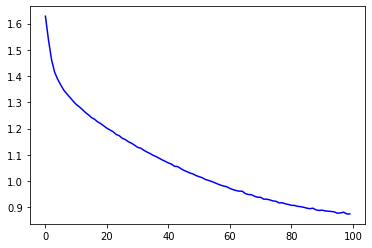

In [16]:
plt.plot(range(epoch), losses, 'b')

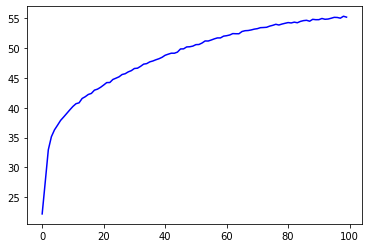

In [17]:
plt.plot(range(epoch), accuracies, 'b')

In [18]:
correct = 0
total = 0

target_out = []
pred_out = []
with torch.no_grad():
    for (i, data) in enumerate(test_loader):
        images, labels = data[0].to(torch.device('cuda')), data[1].to(torch.device('cuda'))
        # Predict the class of the image
        images = images.reshape(100, -1)
        outputs = cifarModel.forward(images)
        _, predicted = torch.max(outputs.data, 1)

        pred_out += predicted.tolist()
        target_out += labels.tolist()


loss_avg = curr_loss / len(train_loader)

acc = accuracy_score(y_true, y_pred)

precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=1)


precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)


precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=1)


perf_metrics = {
    'loss': [loss_avg],
    'accuracy': [acc*100],
    'precision_micro': [precision_micro*100],
    'recall_micro': [recall_micro*100],
    'f1_micro': [f1_micro*100],
    'precision_macro': [precision_macro*100],
    'recall_macro': [recall_macro*100],
    'f1_macro': [f1_macro*100],
    'precision_weighted': [precision_weighted*100],
    'recall_weighted': [recall_weighted*100],
    'f1_weighted': [f1_weighted*100]
}

perf_metrics_df = pd.DataFrame(perf_metrics)
display(perf_metrics_df)


,loss,accuracy,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
0,0.875101,55.162,55.162,55.162,55.162,84.941871,55.162,47.507079,84.941871,55.162,47.507079
